In [1]:
%load_ext autoreload
%autoreload 2

import json
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns

from biobank_olink.constants import PROJECT_ROOT

sns.set()

In [2]:
results = [json.load(p.open()) for p in (PROJECT_ROOT / "results").iterdir()]
results = pd.DataFrame(chain.from_iterable(results))

targets = ["SBP", "DBP", "PP"]
panels = ["ALL", "INFLAMMATION"]

results_base = results.loc[
    results.interactions.isin((0, np.nan, None)) & results.n_best_feats.isin((0, np.nan, None))]

In [3]:
results_xgb = results_base.loc[results_base.model == "XGBOOST"]
results_xgb.loc[:, "feat_importance"] = results_xgb.feat_importance.apply(
    lambda x: x[0] if isinstance(x, list) else x)
agg_values = {f"mean_{v}": (v, "mean") for v in
              ["auc_score", "num_trials", "best_trial_no", "n_estimators"]}
results_xgb.groupby(["model", "panel", "target", "nan_th"]).agg(**agg_values,
                                                                count=("model", 'size'))

mean_auc_score  mean_num_trials  \
model   panel target nan_th                                    
XGBOOST ALL   DBP    0.0           0.784605            307.0   
              PP     0.0           0.726938            307.0   
              SBP    0.0           0.800624            307.0   

                             mean_best_trial_no  mean_n_estimators  count  
model   panel target nan_th                                                
XGBOOST ALL   DBP    0.0                  263.8             4318.0      5  
              PP     0.0                  253.4             4644.2      5  
              SBP    0.0                  242.4             4231.6      5

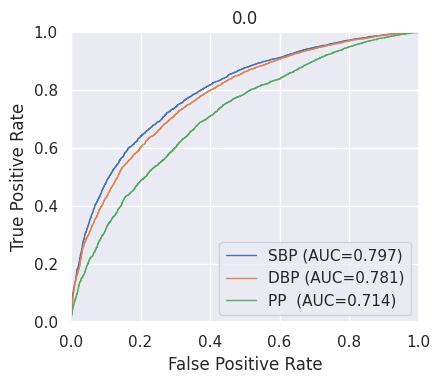

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def plot_auc_curve_by_panels(results, res_feat):
    plt.figure(figsize=(12, 4))
    for i, feat in enumerate(results[res_feat].unique(), 1):
        plt.subplot(1, 3, i)
        plt.xlim([0, 1.0])
        plt.ylim([0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(str(feat).title())

        for target in targets:
            single_case = results.loc[(results.target == target) & (results[res_feat] == feat)]
            if single_case.empty:
                continue
            y_test, y_prob = single_case["y_test"].values, single_case["y_proba"].values
            y_test, y_prob = np.concatenate(y_test), np.concatenate(y_prob)

            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc_score = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1, label=f"{target:<3} (AUC={auc_score:.3f})")

        plt.legend(loc='lower right')
    plt.tight_layout()


plot_auc_curve_by_panels(results_xgb.loc[results_xgb.panel == "ALL"], "nan_th")
plt.show()

In [10]:
results_xgb = results_xgb.loc[results_xgb.nan_th == 0].copy()

## Feature importances

In [12]:
feat_imps = results_xgb.loc[
    (results_xgb.target == "SBP") & (results_xgb.panel == "ALL")].shap_importance
feat_imps = pd.DataFrame(list(feat_imps.values)).T.sort_values(0, ascending=False)
feat_imps.rank(ascending=False).astype(int)

,0,1,2,3,4
REN,1,1,1,1,1
PTPRB,2,2,2,2,3
ACTA2,3,3,3,3,2
NCAN,4,18,19,9,9
CHGB,5,14,8,4,4
...,...,...,...,...,...
ATXN2L,2689,2430,2636,2604,2666
BAG4,2689,1789,2154,2320,2499
BAP18,2689,2549,2209,2190,2096
GLIPR1,2689,2704,2636,2604,2713


In [14]:
from biobank_olink.dataset import get_olink_panel_mapping, compute_correlations_in_df

ol_df_corr = compute_correlations_in_df(None, shape=(53029, 2923))
corr_th = 0.8
mask = np.triu(np.ones(ol_df_corr.shape), k=1).astype(bool)
high_corr = ol_df_corr.where(mask)
correlated_cols = {column: dict(zip(high_corr.columns[high_corr[column] > corr_th].tolist(),
                                    high_corr[column][high_corr[column] > corr_th].tolist()))
                   for column in high_corr.columns}

assays_mapping = get_olink_panel_mapping()


def olink_to_panels(olink):
    return [
        panel
        for panel, olinks in assays_mapping.items()
        if olink in olinks
    ]


def get_feat_imps(res, panel):
    feat_imps = (
        res.loc[(res.panel == panel)]
        .groupby("target").shap_importance
        .apply(lambda x: pd.DataFrame(x.values.tolist()).mean().sort_values(ascending=False))
        .unstack("target")
    )
    present_targets = [col for col in targets if col in feat_imps.columns]
    feat_imps = feat_imps[present_targets]
    feat_ranks = feat_imps.rank(ascending=False)
    feat_ranks.columns = [f"{col}_rank" for col in feat_ranks.columns]
    feat_imps = pd.concat([feat_imps, feat_ranks], axis=1)
    feat_imps = feat_imps[[f"{col}{suffix}" for col in present_targets for suffix in ["", "_rank"]]]
    return feat_imps


feat_imps = get_feat_imps(results_xgb, "ALL")
feat_imps["panel"] = feat_imps.index.map(olink_to_panels)
feat_imps[f"correlates_with (corr>{corr_th})"] = feat_imps.index.map(correlated_cols)
feat_imps.sort_values("SBP", ascending=False)

[Memory]12.6s, 0.2min   : Loading compute_correlations_in_df...


,SBP,SBP_rank,DBP,DBP_rank,PP,PP_rank,panel,correlates_with (corr>0.8)
REN,1121.374390,1.0,1218.675586,1.0,461.304834,1.0,[cardiometabolic],{}
PTPRB,435.034253,2.0,323.489221,2.0,184.182700,7.0,[cardiometabolic],{}
ACTA2,390.670874,3.0,293.277606,3.0,215.095645,4.0,[cardiometabolic],{}
CHGB,242.617920,4.0,143.855743,24.0,268.690659,2.0,[neurology],{}
AMIGO2,240.124603,5.0,104.534326,40.0,175.729245,9.0,[oncology],{}
...,...,...,...,...,...,...,...,...
EVI5,0.534626,2711.0,0.594973,2708.0,1.597260,2669.0,[inflammation],"{'ABL1': 0.8065710177165536, 'AK2': 0.84354134..."
MAP2K1,0.487645,2712.0,1.732561,2584.0,2.178231,2595.0,[oncology],"{'ANXA4': 0.8102002744006099, 'AP3B1': 0.80798..."
ATXN2L,0.476171,2713.0,1.485107,2624.0,1.517962,2672.0,[neurology],{}
ATG16L1,0.106493,2714.0,0.884322,2695.0,1.221620,2691.0,[oncology],"{'ABL1': 0.8525169206924751, 'ACOT13': 0.83452..."


## export all feature importances

In [126]:
from biobank_olink.constants import PROJECT_DATA

feat_importances_dir = PROJECT_DATA / "feat_importances"
feat_importances_dir.mkdir(exist_ok=True)

for study_name in results_base.study_name.unique():
    series = []
    study_res = results.loc[results.study_name == study_name]

    feat_imps = study_res.feat_importance
    series.append(feat_imps.apply(pd.Series).mean())
    series.append(feat_imps.apply(pd.Series).rank(ascending=False, axis=1).mean())

    shap_imps = study_res.shap_importance
    series.append(shap_imps.apply(pd.Series).mean())
    series.append(shap_imps.apply(pd.Series).rank(ascending=False, axis=1).mean())

    importance = pd.concat(series, axis=1)
    importance.columns = ["feat_importance", "feat_importance_rank",
                          "shap_importance", "shap_importance_rank"]
    importance["panel"] = importance.index.map(olink_to_panels)
    importance[f"correlates_with (corr>{corr_th})"] = importance.index.map(correlated_cols)
    importance.to_csv(feat_importances_dir / f"{study_name}.csv")

## LogisticRegressions - interactions

In [60]:
res_inter = results.loc[results.interactions > 0]
res_inter.groupby(["model", "panel", "target", "interactions"]).agg(**agg_values,
                                                                    count=("model", 'size'))

mean_auc_score  mean_num_trials  \
model panel target interactions                                    
lr    all   DBP    10.0                0.806233            221.4   
            PP     10.0                0.736474            206.6   
            SBP    10.0                0.818562            223.0   

                                 mean_best_trial_no  mean_n_estimators  count  
model panel target interactions                                                
lr    all   DBP    10.0                       192.4                NaN      5  
            PP     10.0                       164.8                NaN      5  
            SBP    10.0                       176.6                NaN      5

In [63]:
get_feat_imps(res_inter, "all").sort_values("SBP", ascending=False)

,SBP,SBP_rank,DBP,DBP_rank,PP,PP_rank
REN,0.027764,1.0,0.029997,1.0,0.012055,1.0
CHGB,0.009412,2.0,0.006543,5.0,0.008458,2.0
ACTA2,0.008610,3.0,0.006961,4.0,0.005572,4.0
VWC2,0.008083,4.0,0.006155,9.0,0.004222,16.0
CRIP2,0.007592,5.0,0.008815,2.0,0.004981,10.0
...,...,...,...,...,...,...
SPINK6*ADGRG2,NaN,NaN,NaN,NaN,0.000365,749.0
SPINK6*AMIGO2,NaN,NaN,NaN,NaN,0.000991,315.0
SPINK6*FCGR2B,NaN,NaN,NaN,NaN,0.000387,725.0
SPINK6*LSP1,NaN,NaN,NaN,NaN,0.000503,611.0


## N best features

In [373]:
res_n_best = results.loc[results.n_best_feats.notna()]
res_n_best.groupby(["model", "panel", "target", "n_best_feats"]).agg(**agg_values,
                                                                     count=("model", 'size'))

mean_auc_score  mean_num_trials  \
model panel target n_best_feats                                    
lr    all   DBP    200.0               0.780377            227.2   
                   500.0               0.791994            207.2   
            PP     200.0               0.709120            226.2   
                   500.0               0.724223            205.8   
            SBP    200.0               0.776875            226.8   
                   500.0               0.796892            206.0   

                                 mean_best_trial_no  mean_reg_alpha  count  
model panel target n_best_feats                                             
lr    all   DBP    200.0                       85.6             NaN      5  
                   500.0                       74.6             NaN      5  
            PP     200.0                       56.2             NaN      5  
                   500.0                       46.6             NaN      5  
            SBP    200.0                       63.6             NaN      5  
                   500.0                       96.4             NaN      5

In [377]:
feat_imps_n_best200 = get_feat_imps(res_n_best.loc[res_n_best.n_best_feats == 200],
                                    "all").sort_values("SBP", ascending=False)
feat_imps_n_best200

,SBP,SBP_rank,DBP,DBP_rank,PP,PP_rank
REN,0.053249,1.0,0.055465,1.0,0.034907,1.0
NTRK3,0.016559,2.0,0.016539,3.0,0.008334,28.0
SPINK6,0.016470,3.0,0.014761,7.0,0.014470,8.0
LDLR,0.015345,4.0,0.007389,42.0,NaN,NaN
CRIP2,0.014823,5.0,0.017034,2.0,0.017069,5.0
...,...,...,...,...,...,...
TNFRSF9,NaN,NaN,NaN,NaN,0.007023,40.0
TNFSF10,NaN,NaN,NaN,NaN,0.001617,166.0
TRAF2,NaN,NaN,NaN,NaN,0.004408,88.0
TSHB,NaN,NaN,0.009303,24.0,NaN,NaN


In [379]:
feat_imps_n_best500 = get_feat_imps(res_n_best.loc[res_n_best.n_best_feats == 500],
                                    "all").sort_values("SBP", ascending=False)
feat_imps_n_best500

,SBP,SBP_rank,DBP,DBP_rank,PP,PP_rank
REN,0.031186,1.0,0.033767,1.0,0.018394,1.0
CHGB,0.011459,2.0,0.008744,5.0,0.013755,2.0
ACTA2,0.010796,3.0,0.008771,4.0,0.007913,5.0
CRIP2,0.008242,4.0,0.010294,2.0,0.007889,6.0
EFNA1,0.008216,5.0,NaN,NaN,0.010229,3.0
...,...,...,...,...,...,...
UXS1,NaN,NaN,NaN,NaN,0.001989,188.0
VSIG4,NaN,NaN,NaN,NaN,0.001965,190.0
WAS,NaN,NaN,0.000904,369.0,NaN,NaN
WFDC2,NaN,NaN,NaN,NaN,0.003842,51.0


In [385]:
n = 10
len(feat_imps_n_best500.index[:n].intersection(feat_imps_n_best200.index[:n])) / n

0.6